In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Union

In [99]:
sns.set_theme(style="whitegrid")

In [9]:
df = pd.read_csv("cs.csv", index_col=0)

In [21]:
df['year'] = df['date_add'].str[-4:].astype(int)

In [144]:
def vec_dt_replace(series, year=None, month=None, day=None):
    return pd.to_datetime(
        {'year': series.dt.year if year is None else year,
         'month': series.dt.month if month is None else month,
         'day': series.dt.day if day is None else day})

In [146]:
df['uniform_dates'] = vec_dt_replace(pd.to_datetime(df['date_add']), year=2020)

In [133]:
df['day_month'] = df['date_add'].str[:-5]

In [464]:
df_1720 = df[(df['season'].isin(['F16', 'F17', 'F18', 'F19', 'F20']))]

In [465]:
df.head(2)

,institution,major,degree,season,decisionfin,method,decdate,decdate_ts,gpafin,grev,...,new_gre,sub,status,date_add,date_add_ts,comment,year,month_day,day_month,uniform_dates
0,Cornell University,CS,PhD,F21,Interview,E-mail,13-01-2021,1.610518e+09,NaN,NaN,...,NaN,NaN,International with US Degree,13-01-2021,1610517600,Got an interview from Cornell (Machine Learnin...,2021,13-01,13-01,2020-01-13
1,Virginia Tech,CS,PhD,F21,Interview,E-mail,12-01-2021,1.610431e+09,NaN,NaN,...,NaN,NaN,International with US Degree,13-01-2021,1610517600,Scientific Computing,2021,13-01,13-01,2020-01-13


In [174]:
df.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpafin', 'grev', 'grem', 'grew', 'new_gre',
       'sub', 'status', 'date_add', 'date_add_ts', 'comment', 'year',
       'month_day', 'day_month', 'uniform_dates'],
      dtype='object')

### Make it easier to filter through programs using the decision, the institution, gre, gpa, etc.

In [334]:
def create_filter(df,
                  degree: str = None,
                  decisionfin: Union[str, list] = None,
                  institution: Union[str, list] = None,
                  gpa: bool = False,
                  gre: bool = False):
    filt = [True] * len(df)
    if degree is not None:
        filt = (filt) & (df['degree'] == degree)
    if decisionfin is not None:
        if isinstance(decisionfin, str):
            filt = (filt) & (df['decisionfin'].str.contains(decisionfin, case=False))
        elif isinstance(decisionfin, list):
            filt = (filt) & (df['decisionfin'].isin(decisionfin))
    if institution is not None:
        if isinstance(institution, str):
            filt = (filt) & (df['institution'].str.contains(institution, case=False))
        elif isinstance(institution, list):
            filt = (filt) & (df['institution'].isin(institution))
    if gpa:
        filt = (filt) & (~df['gpafin'].isna()) & (df['gpafin'] <= 4)
    if gre:
        filt = (filt) & (~df['grev'].isna()) & (~df['grem'].isna()) & (~df['grew'].isna()) & (df['new_gre'])
    
    return filt

### Actual function that generates the images

In [392]:
def get_uni_stats(u_df, search: str, title: str = None, degree: str = 'MS', field: str = 'CS'):
    title = title if title is not None else search
    if degree not in ['MS', 'PhD', 'MEng', 'MFA', 'MBA', 'Other']:
        degree = 'MS'

    flatui = ["#2eff71", "#ff0000", "#0000ff"]
    sns.set_palette(flatui)

    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(20, 10)
    
    # Get GPA stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected'], institution = search, gpa = True)
    sns.histplot(data=u_df[mscs_filt],
                 x='gpafin',
                 hue='decisionfin',
                 hue_order=['Accepted', 'Rejected'],
                 bins=10,
                 ax=ax[0])
    ax[0].set_xlabel("GPA")
    ax[0].set_ylabel("Count")
    ax[0].set_title("GPA Distribution")
    leg = ax[0].get_legend()
    if leg is not None:
        leg.set_title('Decision')

    # Get GRE stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected'], institution = search, gre = True)
    dfq = u_df[mscs_filt][['grem', 'decisionfin']]
    dfq = dfq.assign(gre_type='Quant')
    dfq.columns = ['score', 'decisionfin', 'gre_type']

    dfv = u_df[mscs_filt][['grev', 'decisionfin']]
    dfv = dfv.assign(gre_type='Verbal')
    dfv.columns = ['score', 'decisionfin', 'gre_type']

    cdf = pd.concat([dfq, dfv])
    sns.boxplot(data=cdf,
                x='gre_type',
                y='score',
                hue='decisionfin',
                linewidth=2,
                hue_order=['Accepted', 'Rejected'],
                ax=ax[1])
    leg = fig.axes[1].get_legend()
    if leg is not None:
        leg.set_title('Decision')
    ax[1].set_xlabel("GRE Section")
    ax[1].set_ylabel("Score")
    ax[1].set_title("GRE Score distribution")

    # Timeline stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected', 'Interview'], institution = search)
    mscs_filt = (mscs_filt) & (u_df['uniform_dates'].astype(str) < '2020-07-00')
    sns.histplot(data=u_df[mscs_filt],
                 x='uniform_dates',
                 hue='decisionfin',
                 cumulative=True,
                 discrete=False,
                 element='step',
                 fill=False,
                 hue_order=['Accepted', 'Rejected', 'Interview'],
                 ax=ax[2])

    X = plt.gca().xaxis
    X.set_major_formatter(mdates.DateFormatter('%b'))
    leg = fig.axes[2].get_legend()
    if leg is not None:
        leg.set_title('Decision')
    ax[2].set_xlabel("Date")
    ax[2].set_ylabel("Count")
    ax[2].set_title("Cumsum of decisions")
    
    fig.suptitle(title + ', ' + field + ' ' + degree, size='xx-large')
    plt.savefig(title + '_' + field + ' ' + degree + '.png')
    fig.show()

<ipython-input-467-45da56a16265>:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


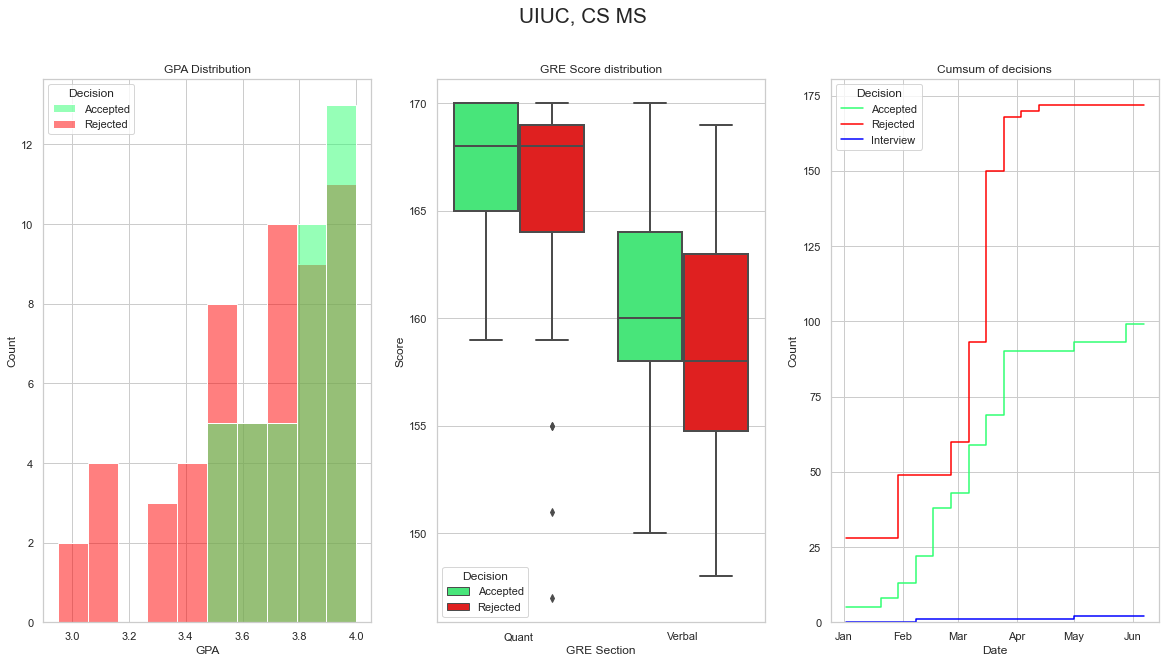

In [468]:
get_uni_stats(df_1720, 'UIUC', 'UIUC', 'MS', 'CS')

## Other things you could analyze

For instance how many interviews per university, and thus know how likely it is that the interview process is a must if you wanna be accepted.

### Bad interview analysis

In [ ]:
df_1720['is_int'] = 0

In [ ]:
df_1720.loc[df_1720['decisionfin'] == 'Interview', 'is_int'] = 1

In [372]:
df_1720.groupby(by='institution').agg({'is_int': sum}).sort_values(by='is_int', ascending=False).head(30)

,is_int
institution,
Columbia University,21
Stanford University,14
"University Of California, Berkeley",11
Massachusetts Institute Of Technology (MIT),8
University Of Toronto,8
University Of Southern California,8
University Of Notre Dame,8
UC Berkeley,7
Duke University,6
